In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../DATA/RSCCASN.csv',parse_dates=True,index_col='DATE')

In [3]:
df.columns=['Sales']

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [5]:
df.head()

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


<AxesSubplot:xlabel='DATE'>

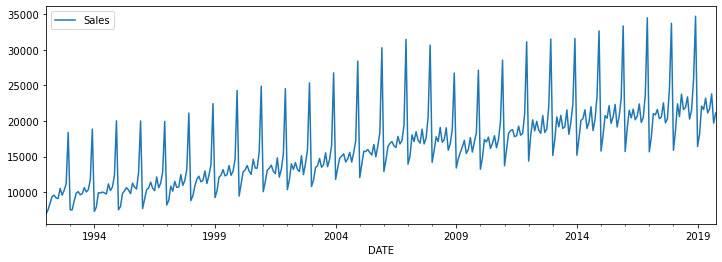

In [6]:
df.plot(figsize=(12,4))

In [7]:
test_size = 18
test_ind = len(df)- test_size

In [8]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
scaler = MinMaxScaler()

In [11]:
scaler.fit(train)

MinMaxScaler()

In [12]:
scaled_train = scaler.transform(train)

In [13]:
scaled_test = scaler.transform(test)

In [14]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [15]:
length = 12
generator = TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=1)

In [16]:
X,y = generator[0]

In [17]:
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [18]:
y

array([[0.02047633]])

In [19]:
len(X[0])

12

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [21]:
n_features = 1

In [22]:
model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss='mse')

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

In [24]:
early_stop = EarlyStopping(monitor='val_loss',patience = 2)

In [25]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,length=length,batch_size=1)

In [26]:
model.fit(generator,epochs=20,validation_data = validation_generator,callbacks = [early_stop])

Epoch 1/20
304/304 [==============================] - 2s 4ms/step - loss: 0.0280 - val_loss: 0.0149
Epoch 2/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0170 - val_loss: 0.0173
Epoch 3/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0097 - val_loss: 0.0135
Epoch 4/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0075 - val_loss: 0.0020
Epoch 5/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0039 - val_loss: 0.0049
Epoch 6/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0023 - val_loss: 0.0029


In [27]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

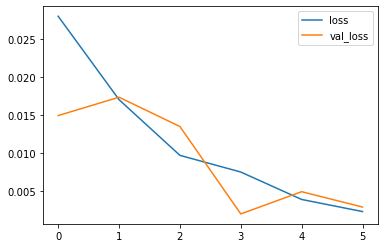

In [28]:
losses.plot()

In [29]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [30]:
true_predictions=scaler.inverse_transform(test_predictions)

In [32]:
test['prediction']=  true_predictions

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_9260/668116505.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction']=  true_predictions


<AxesSubplot:xlabel='DATE'>

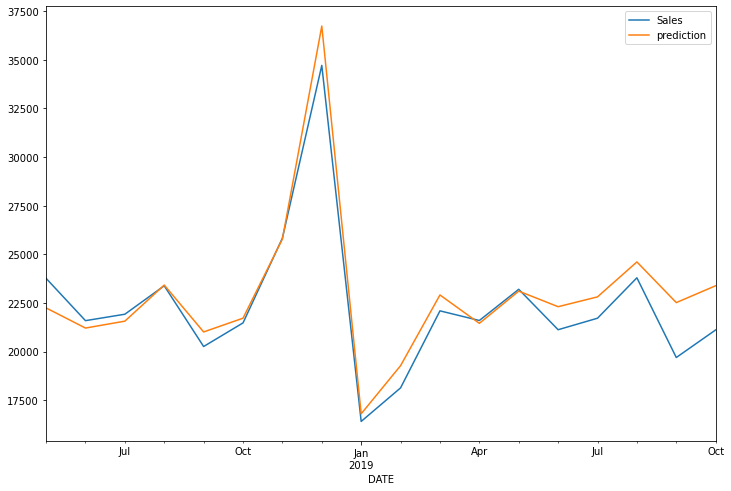

In [33]:
test.plot(figsize=(12,8))

In [34]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [35]:
length = 12
generator = TimeseriesGenerator(scaled_full_data,scaled_full_data,length=length,batch_size=1)

In [36]:
model= Sequential()
model.add(LSTM(100, activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss = 'mse')

In [37]:
model.fit(generator , epochs = 8)

Epoch 1/8
322/322 [==============================] - 2s 3ms/step - loss: 0.0234
Epoch 2/8
322/322 [==============================] - 1s 3ms/step - loss: 0.0176
Epoch 3/8
322/322 [==============================] - 1s 3ms/step - loss: 0.0082
Epoch 4/8
322/322 [==============================] - 1s 3ms/step - loss: 0.0027
Epoch 5/8
322/322 [==============================] - 1s 3ms/step - loss: 0.0022
Epoch 6/8
322/322 [==============================] - 1s 3ms/step - loss: 0.0033
Epoch 7/8
322/322 [==============================] - 1s 3ms/step - loss: 0.0014
Epoch 8/8
322/322 [==============================] - 1s 3ms/step - loss: 0.0014


In [41]:
forecast = []

periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [43]:
forecast =full_scaler.inverse_transform(forecast)

In [46]:
forecast

array([[24950.34684181],
       [34456.32789707],
       [16583.06339526],
       [18036.1939292 ],
       [21116.35819578],
       [20765.23911214],
       [22285.63794756],
       [20458.55620098],
       [20985.18641472],
       [22791.72669315],
       [19318.42775679],
       [20473.53818226]])

In [44]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [45]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [47]:
 forecast_df = pd.DataFrame(data=forecast,index = forecast_index,columns=['forecast'])

<AxesSubplot:xlabel='DATE'>

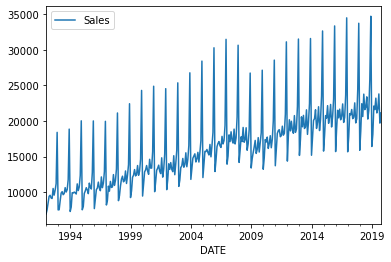

In [48]:
df.plot()

In [49]:
forecast_df

,forecast
2019-11-01,24950.346842
2019-12-01,34456.327897
2020-01-01,16583.063395
2020-02-01,18036.193929
2020-03-01,21116.358196
2020-04-01,20765.239112
2020-05-01,22285.637948
2020-06-01,20458.556201
2020-07-01,20985.186415
2020-08-01,22791.726693


(576.0, 611.0)

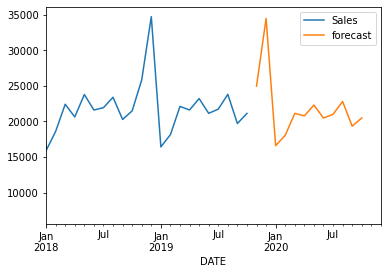

In [52]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')